# Credit Card Fraud Detection with AutoXGB

## Part 3 - Running AutoXGB
___
Reference: https://github.com/abhishekkrthakur/autoxgb

### Install AutoXGB

In [ ]:
# !pip install autoxgb

### Import dependencies and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from autoxgb import AutoXGB
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display
pd.set_option('display.max_columns', None)

### Run AutoXGB Training and Prediction

In [2]:
# Define required parameters
train_filename = "data/processed/train.csv" # Path to training dataset
output = "output" # Name of output folder

# Set optional parameters
test_filename = "data/processed/test.csv"
task = "classification"
targets = ["TX_FRAUD"]
use_gpu = True
num_folds = 5
seed = 42
num_trials = 100
time_limit = 400
fast = False

# Start AutoXGB training
axgb = AutoXGB(
            train_filename=train_filename,
            output=output,
            test_filename=test_filename,
            task=task,
            targets=targets,
            use_gpu=use_gpu,
            num_folds=num_folds,
            seed=seed,
            num_trials=num_trials,
            time_limit=time_limit,
            fast=fast,
)

axgb.train()

2021-11-21 14:42:33.998 | INFO     | autoxgb.autoxgb:__post_init__:42 - Output directory: output
2021-11-21 14:42:34.002 | INFO     | autoxgb.autoxgb:_process_data:149 - Reading training data
2021-11-21 14:42:34.431 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 5.67 Mb (77.3% reduction)
2021-11-21 14:42:34.443 | INFO     | autoxgb.autoxgb:_determine_problem_type:140 - Problem type: binary_classification
2021-11-21 14:42:34.572 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 1.86 Mb (77.3% reduction)
2021-11-21 14:42:34.576 | INFO     | autoxgb.autoxgb:_create_folds:58 - Creating folds
2021-11-21 14:42:34.634 | INFO     | autoxgb.autoxgb:_process_data:170 - Encoding target(s)
2021-11-21 14:42:34.647 | INFO     | autoxgb.autoxgb:_process_data:195 - Found 0 categorical features.
2021-11-21 14:42:35.063 | INFO     | autoxgb.autoxgb:_process_data:236 - Model config: train_filename='data/processed/train.csv' test_filename='data/proces

Total time taken to train and predict: 14 mins

### Setup test dataset

In [3]:
# Import dataset and define target variable
test_df = pd.read_csv('data/processed/test.csv')
target = 'TX_FRAUD'

# Get y true labels
y_test = test_df[target]

### Get predictions on test set

In [4]:
# View probability predictions from AutoXGB
test_predictions = pd.read_csv('output/test_predictions.csv')
test_predictions.head()

,id,0,1
0,0,0.950455,0.049545
1,1,0.997364,0.002636
2,2,0.995619,0.004381
3,3,0.976451,0.023549
4,4,0.994208,0.005792


In [5]:
# Set threshold (default = 0.5)
threshold = 0.5

# Generate predicted labels
test_predictions['label'] = test_predictions['1'].apply(lambda x: 0 if x < threshold else 1)
preds = test_predictions.iloc[: , 3:] # Drop unnecessary columns
preds.head()

,label
0,0
1,0
2,0
3,0
4,0


### Review performance metrics

In [6]:
# Define function to consolidate and display performance metrics
def gen_performance_metrics(y_true, y_preds, model_name, round_to=3):
    accuracy = round(metrics.accuracy_score(y_true, y_preds), round_to)
    f1_score = round(metrics.f1_score(y_true, y_preds), round_to)
    precision = round(metrics.precision_score(y_true, y_preds), round_to)
    avg_precision = round(metrics.average_precision_score(y_true, y_preds), round_to)
    recall = round(metrics.recall_score(y_true, y_preds), round_to)

    df = pd.DataFrame([[model_name, accuracy, f1_score, precision, avg_precision, recall]], 
                        columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Average Precision', 'Recall'])
    
    display(df)
    display(metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_preds))

,Model,Accuracy,F1 Score,Precision,Average Precision,Recall
0,AutoXGB,0.996,0.76,0.845,0.586,0.69


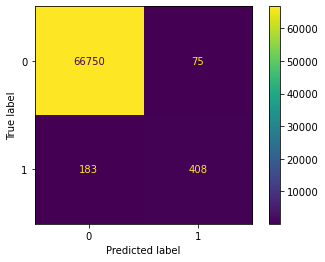

In [7]:
# Show performance assessment
gen_performance_metrics(y_test, preds, 'AutoXGB')